***
# Lab 2 ML7331
> ### By Allen Hoskins, Brittany Lewandowski, Alexy Morris, Fidel Tamares


***

In [154]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_predict
from sklearn.linear_model import LogisticRegression,SGDClassifier,LogisticRegressionCV, ElasticNet
from sklearn.feature_selection import SelectPercentile,f_regression
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib
from graphviz.graphs import Digraph
from mlxtend.evaluate import paired_ttest_5x2cv
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import time
import warnings

#remove warnings after verifying code
warnings.filterwarnings("ignore")

In [127]:
df = pd.read_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/airline_merged.csv',low_memory=False)

In [128]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 45 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   year                   int64  
 2   month                  int64  
 3   day                    int64  
 4   day_of_week            int64  
 5   airline_cd             object 
 6   airline_name           object 
 7   flight_number          int64  
 8   tail_number            object 
 9   origin_airport         object 
 10  airport_origin         object 
 11  city_origin            object 
 12  state_origin           object 
 13  country_origin         object 
 14  latitude_origin        float64
 15  longitude_origin       float64
 16  destination_airport    object 
 17  airport_destination    object 
 18  city_destination       object 
 19  state_destination      object 
 20  country_destination    object 
 21  latitude_destination   float64
 22  longitude_destinat


**Data Dictionary:**
***

| Attribute Name | Attribute Description | Non-null Count | Attribute Data Type|
| :--- | :--- | :---| :---|
| year | Year data was collected |5819079|int |
| month | Month data was collected |5819079| int |
| day | Day data was collected (1-25) |5819079| int |
| day_of_week | Day of the week data was collected (1-7) |5819079|int |
| airline_name | Name of airline ex) Alaska Airlines Inc. |5819079| object |
| airline_cd | Code for airline ex) AA |5819079|object |
| flight_number | Unique identifier for each flight |5804358| int |
| tail_number  | Unique identifier for a plane | 5819079|object |
| origin_airport | Code of origin airport ex) DFW for Dallas Fort Worth International Airport |5819079| object |
| airport_origin | Airport flight originates from ex) San Francisco International Airport  | 5332914|object  |
| city_origin | City the flight came from | 5332914|object |
| state_origin | State the flight came from | 5332914|object |
| country_origin | Country flight came from | 5332914|object |
| latitude_origin | Latitude coordinates the flight came from | 5332914|float |
| longitude_origin | Longitude coordinates the flight came from | 5332914|float |
| destination_airport | Code of destination airport ex) DFW for Dallas Fort Worth International Airport |5819079| object |
| airport_destination | Name of destination airport ex) Dallas Fort Worth International Airport |5332914|	object |
| city_destination | City of destination | 5332914|object |
| state_destination | State of destination | 5332914|object |
| country_destination | Country of destination |5332914| object |
| latitude_destination | Latitude coordinates of flight destination | 5332914|float |
| longitude_destination | Longitude coordinates of flight destination |5332914| float |
| scheduled_departure | Time of flight departure | 5819079|int |
| departure_time | Time flight departed | 5732926|float |
| departure_delay | Time flights are delayed from departure |5732926| float |
| taxi_out | Time spent taxiing to the runway  |5730032| float |
| wheels_off | Time spent removing wheels  | 5730032|float  |
| scheduled_time | When flight is scheduled to back up from gate | 5819073|float |
| elapsed_time | Calculated column derived by adding taxi & air time together |5714008| float |
| air_time | Time flight spends in the air | 5714008|float |
| distance | Distance traveled by flights | 5819079|int |
| wheels_on | Time spent |5726566| float |
| taxi_in | Time spent taxiing to the gate | 5726566|float |
| scheduled_arrival | Scheduled flight arrival time |5819079| int |
| arrival_time | Time flight actually arrived | 5726566|float |
| arrival_delay |Time flights are delayed from arrival |5714008| float |
| diverted | Binary indicator of if a flight was diverted or not (0,1) |5819079| int |
| cancelled | Binary indicator of if a flight was canceled or not (0,1) |5819079| int |
| cancellation_reason | Reason for flight cancellation | 89884|object |
| air_system_delay | Flight delays due to air systems |1063439| float |
| security_delay | Flight delays due to security issues |1063439| float |
| airline_delay | Flight delays due to an airline specific problem |1063439| float |
| late_aircraft_delay | Flight delays due to an aircraft being late | 5819079|float |
| weather_delay  | Flight delays due to weather | 1063439|float |

***

In [129]:
pd.set_option('display.max_columns', None)

In [130]:
#removing unwanted column from previous export
df = df.drop(columns =['Unnamed: 0'],axis =1)

In [131]:
#dropping highly correlated columns
#https://www.codegrepper.com/code-examples/python/how+to+drop+highly+correlated+features
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

df = df.drop(columns = to_drop, axis=1)

In [132]:
#selecting subset of data set
airports = ['BHM']

In [133]:
df_air = df.loc[df['origin_airport'].isin(airports)]

In [134]:
df_air.describe()

,year,month,day,day_of_week,flight_number,latitude_origin,longitude_origin,latitude_destination,longitude_destination,scheduled_departure,departure_delay,taxi_out,scheduled_time,wheels_on,taxi_in,scheduled_arrival,diverted,cancelled,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
count,12514.0,12514.000000,12514.000000,12514.000000,12514.000000,1.251400e+04,1.251400e+04,12514.000000,12514.000000,12514.000000,12338.000000,12334.000000,12514.000000,12324.000000,12324.000000,12514.000000,12514.000000,12514.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000
mean,2015.0,6.150951,15.687710,3.879575,2876.476346,3.356294e+01,-8.675355e+01,34.252718,-88.175001,1192.116909,9.032906,13.783525,108.121864,1399.118306,8.632587,1416.011507,0.004075,0.014464,14.805921,0.091635,20.292293,27.732613,2.580827
std,0.0,3.384375,8.763785,1.992624,1951.952017,7.787860e-12,1.647104e-11,4.990106,8.325266,445.126945,43.869223,7.389709,36.974468,458.707388,5.844535,443.946518,0.063711,0.119397,32.820428,3.167858,73.036267,47.048389,16.190917
min,2015.0,1.000000,1.000000,1.000000,3.000000,3.356294e+01,-8.675355e+01,25.793250,-115.152330,500.000000,-20.000000,4.000000,52.000000,3.000000,1.000000,707.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015.0,3.000000,8.000000,2.000000,1051.000000,3.356294e+01,-8.675355e+01,29.980470,-95.339720,745.000000,-5.000000,9.000000,76.000000,952.000000,5.000000,1009.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.0,6.000000,16.000000,4.000000,2525.000000,3.356294e+01,-8.675355e+01,33.640440,-84.426940,1200.000000,-2.000000,12.000000,113.000000,1402.000000,7.000000,1414.000000,0.000000,0.000000,3.000000,0.000000,0.000000,9.000000,0.000000
75%,2015.0,9.000000,23.000000,5.000000,4592.000000,3.356294e+01,-8.675355e+01,39.175400,-83.348840,1609.000000,4.000000,16.000000,123.000000,1823.000000,10.000000,1825.000000,0.000000,0.000000,18.000000,0.000000,10.000000,34.000000,0.000000
max,2015.0,12.000000,31.000000,7.000000,6813.000000,3.356294e+01,-8.675355e+01,42.212060,-73.872610,2055.000000,1988.000000,116.000000,260.000000,2357.000000,150.000000,2325.000000,1.000000,1.000000,493.000000,144.000000,1971.000000,420.000000,240.000000


In [135]:
#selecting columns that are dtype != numeric
non_numeric = df_air.select_dtypes(exclude = np.number).columns

In [136]:
#create binary response for logistic regression
# create a function
def is_delayed(delay,axis=1):
    if delay <= 0:
        return 0
    else:
        return 1
    
# create a new column based on condition
df_air['is_delay'] = df_air.loc[:,'departure_delay'].apply(is_delayed)

/var/folders/cn/_lgzxbk177j14_b82nbl10br0000gn/T/ipykernel_95689/3939397851.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air['is_delay'] = df_air.loc[:,'departure_delay'].apply(is_delayed)


In [137]:
df_air.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12514 entries, 321 to 5817010
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   12514 non-null  int64  
 1   month                  12514 non-null  int64  
 2   day                    12514 non-null  int64  
 3   day_of_week            12514 non-null  int64  
 4   airline_cd             12514 non-null  object 
 5   airline_name           12514 non-null  object 
 6   flight_number          12514 non-null  int64  
 7   tail_number            12510 non-null  object 
 8   origin_airport         12514 non-null  object 
 9   airport_origin         12514 non-null  object 
 10  city_origin            12514 non-null  object 
 11  state_origin           12514 non-null  object 
 12  country_origin         12514 non-null  object 
 13  latitude_origin        12514 non-null  float64
 14  longitude_origin       12514 non-null  float64
 15

In [138]:
#Departure Delay - response
#altered from https://www.statology.org/one-hot-encoding-in-python/

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='error',drop='first')

#perform one-hot encoding on non-numeric column s
encoder_df = pd.DataFrame(encoder.fit_transform(df_air[non_numeric]).toarray())

#merge one-hot encoded columns back with original DataFrame
encoded = df_air.join(encoder_df)

In [139]:
#drop original columns
final_df = encoded.drop(non_numeric, axis=1)

Final data set after One Hot Encoding is 12,514 x 1,777. Below is a condensed view of the data set as 1,777 columns is too long to print.

In [18]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12514 entries, 321 to 5817010
Columns: 1814 entries, day_of_week to 1792
dtypes: float64(1807), int64(7)
memory usage: 173.5 MB


0    12333
1      181
Name: cancelled, dtype: int64


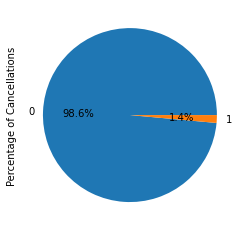

In [19]:
#Checking distribution of our response variables.
#The below code was altered from: https://wellsr.com/python/upsampling-and-downsampling-imbalanced-data-in-python/

print(df_air["cancelled"].value_counts())

df_air.groupby('cancelled').size().plot(kind='pie',
                                       y = "cancelled",
                                       label = "Percentage of Cancellations",
                                       autopct='%1.1f%%');

0    8412
1    4102
Name: is_delay, dtype: int64


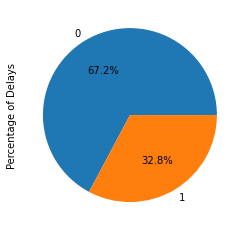

In [20]:
#Checking distribution of our response variables.
#The below code was altered from: https://wellsr.com/python/upsampling-and-downsampling-imbalanced-data-in-python/

print(df_air["is_delay"].value_counts())

df_air.groupby('is_delay').size().plot(kind='pie',
                                       y = "is_delay",
                                       label = "Percentage of Delays",
                                       autopct='%1.1f%%');

> Creating Test and Train Split for Task 1 (Predicting Delay)

In [23]:
#remove target variable and column target was created from training data set
target_delay_cols = ['is_delay','departure_delay']
feature_delay_cols = final_df.loc[:, ~final_df.columns.isin(target_delay_cols)].columns
X_delay = final_df[feature_delay_cols] # Features
y_delay = final_df.is_delay # Target variable

In [24]:
#split original dataset into features and target variable
X_delay_train,X_delay_test,y_delay_train,y_delay_test=train_test_split(X_delay,y_delay,test_size=0.20,random_state=0)

In [25]:
#imputing 0 into NaN values for logistic regression after OHE
X_delay_train = X_delay_train.fillna(0)
X_delay_test = X_delay_test.fillna(0)
y_delay_train = y_delay_train.fillna(0)
y_delay_test = y_delay_test.fillna(0)

In [26]:
#checking shape of data
print('X_delay_train shape: ',X_delay_train.shape,'\n')
print('X_delay_test shape: ',X_delay_test.shape,'\n')
print('y_delay_train shape: ',y_delay_train.shape,'\n')
print('y_delay_test shape: ',y_delay_test.shape)

X_delay_train shape:  (10011, 1775) 

X_delay_test shape:  (2503, 1775) 

y_delay_train shape:  (10011,) 

y_delay_test shape:  (2503,)


> Creating Test and Train Split for Task 2 (Predicting Cancellation)

In [27]:
#remove target variable and column target was created from training data set
target_cancel_cols = ['cancelled','cancellation_reason']
feature_cancel_cols = final_df.loc[:, ~final_df.columns.isin(target_cancel_cols)].columns
X_cancel = final_df[feature_cancel_cols] # Features
y_cancel = final_df.is_delay # Target variable

In [28]:
#split original dataset into features and target variable
X_cancel_train,X_cancel_test,y_cancel_train,y_cancel_test=train_test_split(X_cancel,y_cancel,test_size=0.20,random_state=0)

In [29]:
#imputing 0 into NaN values for logistic regression after OHE
X_cancel_train = X_cancel_train.fillna(0)
X_cancel_test = X_cancel_test.fillna(0)
y_cancel_train = y_cancel_train.fillna(0)
y_cancel_test = y_cancel_test.fillna(0)

In [30]:
#checking shape of data
print('X_cancel_train shape: ',X_cancel_train.shape,'\n')
print('X_cancel_test shape: ',X_cancel_test.shape,'\n')
print('y_cancel_train shape: ',y_cancel_train.shape,'\n')
print('y_cancel_test shape: ',y_cancel_test.shape)

X_cancel_train shape:  (10011, 1776) 

X_cancel_test shape:  (2503, 1776) 

y_cancel_train shape:  (10011,) 

y_cancel_test shape:  (2503,)


# Agglomerative Clustering on RF features:

In [58]:
AG = final_df[["wheels_on","day","taxi_out","taxi_in"]]
AG.head()

,wheels_on,day,taxi_out,taxi_in
321,846.0,1,19.0,6.0
730,823.0,1,9.0,5.0
734,839.0,1,12.0,16.0
2191,1035.0,1,16.0,11.0
2303,1125.0,1,11.0,5.0


In [59]:
AG.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12514 entries, 321 to 5817010
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   wheels_on  12324 non-null  float64
 1   day        12514 non-null  int64  
 2   taxi_out   12334 non-null  float64
 3   taxi_in    12324 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 746.9 KB


In [60]:
#Imputing null and infinity values. 
print(np.any(np.isnan(AG)))
AG_clean = np.nan_to_num(AG)

True


In [62]:
#Normalizing data. 
from sklearn.preprocessing import normalize
data_scaled = normalize(AG_clean)

In [63]:
#Conferting array to a DF. 
d2 = pd.DataFrame(data_scaled, columns = ['wheels_on','day','taxi_out','taxi_in'])
d2.head()

,wheels_on,day,taxi_out,taxi_in
0,0.999722,0.001182,0.022452,0.007090
1,0.999921,0.001215,0.010935,0.006075
2,0.999715,0.001192,0.014299,0.019065
3,0.999824,0.000966,0.015456,0.010626
4,0.999942,0.000889,0.009777,0.004444


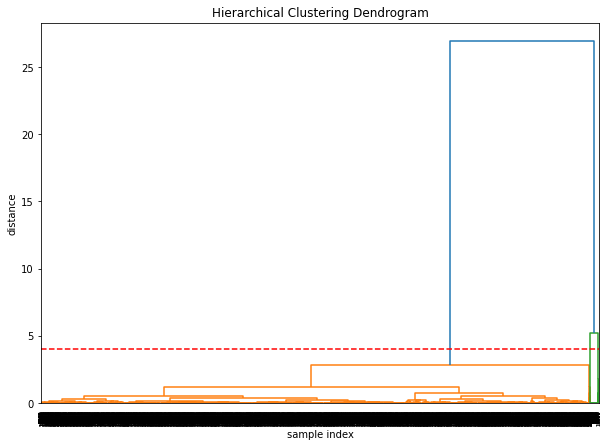

In [64]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("Hierarchical Clustering Dendrogram")  
plt.xlabel('sample index')
plt.ylabel('distance')

dend = shc.dendrogram(shc.linkage(d2, method='ward'))
plt.axhline(y=4, color='r', linestyle='--')
plt.show()

In [65]:
#Importing Allogmerative Clustering library and creating a pipeline. 

from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(d2)

array([0, 0, 0, ..., 0, 0, 0])

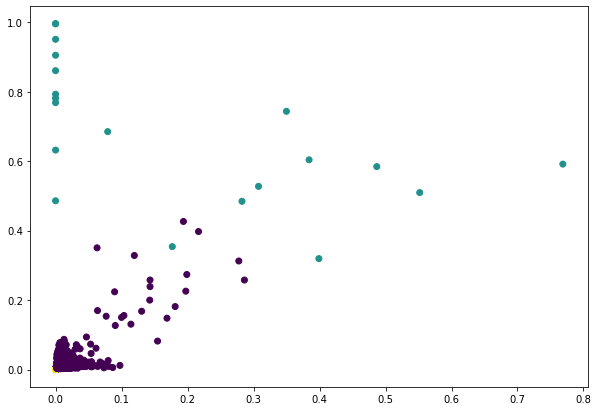

In [66]:
#Visualizing aggglomerative clustering output:
plt.figure(figsize=(10, 7))  
plt.scatter(d2['taxi_in'], d2['taxi_out'], c=cluster.labels_)

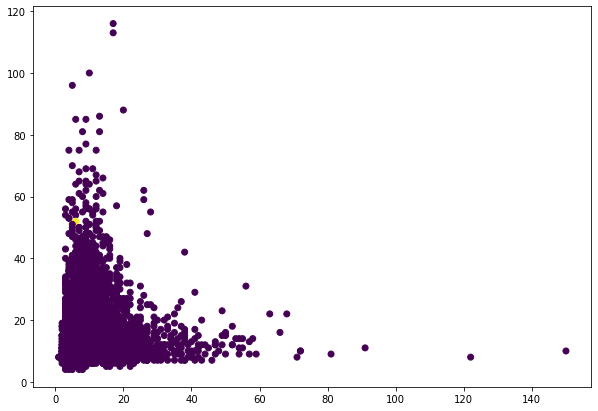

In [67]:
#Visualizing aggglomerative clustering output:
plt.figure(figsize=(10, 7))  
plt.scatter(AG['taxi_in'], AG['taxi_out'], c=cluster.labels_)

# Agglomerative Clustering On Delayed Columns:

In [31]:
AG2 = final_df.loc[:,["air_system_delay","security_delay","airline_delay","late_aircraft_delay","weather_delay"]]
AG2.head()

,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
321,NaN,NaN,NaN,NaN,NaN
730,NaN,NaN,NaN,NaN,NaN
734,NaN,NaN,NaN,NaN,NaN
2191,NaN,NaN,NaN,NaN,NaN
2303,NaN,NaN,NaN,NaN,NaN


In [50]:
#Viewing summary stats from AG2 DF. 
AG2.describe()

,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
count,12514.000000,12514.000000,12514.000000,12514.000000,12514.000000
mean,2.517740,0.015583,3.450695,4.715918,0.438868
std,14.630226,1.306530,31.062207,22.018629,6.745406
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,493.000000,144.000000,1971.000000,420.000000,240.000000


In [38]:
#Summing null values in AG2 DF:
print('Nulls in air_system_delay =', AG2['air_system_delay'].isna().sum())
print('Nulls in security_delay =', AG2['security_delay'].isna().sum())
print('Nulls in airline_delay =', AG2['airline_delay'].isna().sum())
print('Nulls in late_aircraft__delay =', AG2['late_aircraft_delay'].isna().sum())
print('Nulls in weather_delay =', AG2['weather_delay'].isna().sum())

Nulls in air_system_delay = 10386
Nulls in security_delay = 10386
Nulls in airline_delay = 10386
Nulls in late_aircraft__delay = 10386
Nulls in weather_delay = 10386


In [39]:
#Imputing Nulls with 0's:
AG2['air_system_delay'] = AG2['air_system_delay'].fillna(0)
AG2['security_delay'] = AG2['security_delay'].fillna(0)
AG2['airline_delay'] = AG2['airline_delay'].fillna(0)
AG2['late_aircraft_delay'] = AG2['late_aircraft_delay'].fillna(0)
AG2['weather_delay'] = AG2['weather_delay'].fillna(0)

In [44]:
#Verifying nulls have been removed from AG2:
print('Nulls in air_system_delay =', AG2['air_system_delay'].isna().sum())
print('Nulls in security_delay =', AG2['security_delay'].isna().sum())
print('Nulls in airline_delay =', AG2['airline_delay'].isna().sum())
print('Nulls in late_aircraft__delay =', AG2['late_aircraft_delay'].isna().sum())
print('Nulls in weather_delay =', AG2['weather_delay'].isna().sum())

Nulls in air_system_delay = 0
Nulls in security_delay = 0
Nulls in airline_delay = 0
Nulls in late_aircraft__delay = 0
Nulls in weather_delay = 0


In [47]:
#Viewing AG2 DF to verify no more nulls exist:
AG2.head()

,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
321,0.0,0.0,0.0,0.0,0.0
730,0.0,0.0,0.0,0.0,0.0
734,0.0,0.0,0.0,0.0,0.0
2191,0.0,0.0,0.0,0.0,0.0
2303,0.0,0.0,0.0,0.0,0.0


In [45]:
#Normalizing AG2: NOTE THIS DOES NOT CLUSTER AS WELL.
from sklearn.preprocessing import normalize
data_scaled3 = normalize(AG2)

In [48]:
#Converting normalized array to a DF:
delay_norm = pd.DataFrame(data_scaled3, columns = ['air_system_delay','security_delay','airline_delay','late_aircraft_delay','weather_delay'])
delay_norm.head()

,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


In [49]:
#Viewing summary stats from normalized data:
delay_norm.describe()

,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
count,12514.000000,12514.000000,12514.000000,12514.000000,12514.000000
mean,0.061370,0.000354,0.042717,0.080687,0.006942
std,0.222613,0.017237,0.183897,0.261211,0.077518
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("Hierarchical Clustering Dendrogram")  
plt.xlabel('sample index')
plt.ylabel('distance')

dend = shc.dendrogram(shc.linkage(AG2, method='ward'))
plt.show()

In [53]:
#Importing Allogmerative Clustering library and creating a pipeline. 

from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
cluster.fit_predict(AG2)

array([0, 0, 0, ..., 0, 0, 0])

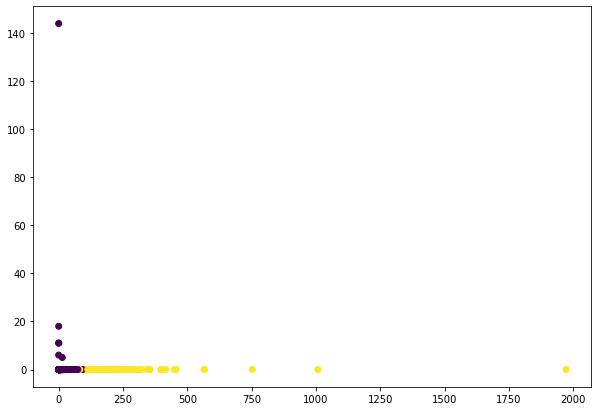

In [54]:
#Visualizing aggglomerative clustering output:
plt.figure(figsize=(10, 7))  
plt.scatter(AG2['airline_delay'], AG2['security_delay'], c=cluster.labels_)

***
## Exceptional Work
***

In [3]:
from sklearn.model_selection import TimeSeriesSplit

In [158]:
df_air[['year', 'month', 'day']] = final_df[['year', 'month', 'day']].astype(str)

/var/folders/cn/_lgzxbk177j14_b82nbl10br0000gn/T/ipykernel_95689/2387628275.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air[['year', 'month', 'day']] = final_df[['year', 'month', 'day']].astype(str)


In [159]:
df_air.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12514 entries, 321 to 5817010
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   12514 non-null  object 
 1   month                  12514 non-null  object 
 2   day                    12514 non-null  object 
 3   day_of_week            12514 non-null  int64  
 4   airline_cd             12514 non-null  object 
 5   airline_name           12514 non-null  object 
 6   flight_number          12514 non-null  int64  
 7   tail_number            12510 non-null  object 
 8   origin_airport         12514 non-null  object 
 9   airport_origin         12514 non-null  object 
 10  city_origin            12514 non-null  object 
 11  state_origin           12514 non-null  object 
 12  country_origin         12514 non-null  object 
 13  latitude_origin        12514 non-null  float64
 14  longitude_origin       12514 non-null  float64
 15

In [160]:
#creating date field for TimeSeriesSplit
df_air['date'] = df_air[['year', 'month', 'day']].agg('-'.join, axis=1)
df_air['date'] = pd.to_datetime(df_air['date'])

/var/folders/cn/_lgzxbk177j14_b82nbl10br0000gn/T/ipykernel_95689/3172663463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air['date'] = df_air[['year', 'month', 'day']].agg('-'.join, axis=1)
/var/folders/cn/_lgzxbk177j14_b82nbl10br0000gn/T/ipykernel_95689/3172663463.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air['date'] = pd.to_datetime(df_air['date'])


In [162]:
df_air = df_air.sort_values(by='date')

In [144]:
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer


In [163]:
df_air.head()

,year,month,day,day_of_week,airline_cd,airline_name,flight_number,tail_number,origin_airport,airport_origin,city_origin,state_origin,country_origin,latitude_origin,longitude_origin,destination_airport,airport_destination,city_destination,state_destination,country_destination,latitude_destination,longitude_destination,scheduled_departure,departure_delay,taxi_out,scheduled_time,wheels_on,taxi_in,scheduled_arrival,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,is_delay,date
321,2015,1,1,4,MQ,American Eagle Airlines Inc.,3488,N620MQ,BHM,Birmingham-Shuttlesworth International Airport,Birmingham,AL,USA,33.56294,-86.75355,MIA,Miami International Airport,Miami,FL,USA,25.79325,-80.29056,600,0.0,19.0,117.0,846.0,6.0,857,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,2015-01-01
11755,2015,1,1,4,WN,Southwest Airlines Co.,1785,N963WN,BHM,Birmingham-Shuttlesworth International Airport,Birmingham,AL,USA,33.56294,-86.75355,HOU,William P. Hobby Airport,Houston,TX,USA,29.64542,-95.27889,1905,4.0,8.0,115.0,2055.0,7.0,2100,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,2015-01-01
11323,2015,1,1,4,OO,Skywest Airlines Inc.,4968,N713SK,BHM,Birmingham-Shuttlesworth International Airport,Birmingham,AL,USA,33.56294,-86.75355,IAH,George Bush Intercontinental Airport,Houston,TX,USA,29.98047,-95.33972,1830,11.0,15.0,112.0,2038.0,5.0,2022,0,0,NaN,10.0,0.0,11.0,0.0,0.0,1,2015-01-01
11069,2015,1,1,4,WN,Southwest Airlines Co.,3490,N933WN,BHM,Birmingham-Shuttlesworth International Airport,Birmingham,AL,USA,33.56294,-86.75355,MCO,Orlando International Airport,Orlando,FL,USA,28.42889,-81.31603,1815,10.0,12.0,85.0,2043.0,5.0,2040,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,2015-01-01
10057,2015,1,1,4,AA,American Airlines Inc.,1224,N4WMAA,BHM,Birmingham-Shuttlesworth International Airport,Birmingham,AL,USA,33.56294,-86.75355,DFW,Dallas/Fort Worth International Airport,Dallas-Fort Worth,TX,USA,32.89595,-97.03720,1710,-4.0,14.0,130.0,1912.0,34.0,1920,0,0,NaN,26.0,0.0,0.0,0.0,0.0,0,2015-01-01


In [164]:
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

In [165]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 11)

df_air.set_index('date', inplace=True)
df_air.sort_index(inplace=True)
X = df_air.drop(labels=['is_delay'], axis=1)
y = df_air['is_delay']

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [166]:
#X_train.index
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11472 entries, 321 to 5346641
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   year                   11472 non-null  object        
 1   month                  11472 non-null  object        
 2   day                    11472 non-null  object        
 3   day_of_week            11472 non-null  int64         
 4   airline_cd             11472 non-null  object        
 5   airline_name           11472 non-null  object        
 6   flight_number          11472 non-null  int64         
 7   tail_number            11469 non-null  object        
 8   origin_airport         11472 non-null  object        
 9   airport_origin         11472 non-null  object        
 10  city_origin            11472 non-null  object        
 11  state_origin           11472 non-null  object        
 12  country_origin         11472 non-null  object        
 1

In [167]:
X_train.head()

,year,month,day,day_of_week,airline_cd,airline_name,flight_number,tail_number,origin_airport,airport_origin,city_origin,state_origin,country_origin,latitude_origin,longitude_origin,destination_airport,airport_destination,city_destination,state_destination,country_destination,latitude_destination,longitude_destination,scheduled_departure,departure_delay,taxi_out,scheduled_time,wheels_on,taxi_in,scheduled_arrival,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,date
321,2015,1,1,4,MQ,American Eagle Airlines Inc.,3488,N620MQ,BHM,Birmingham-Shuttlesworth International Airport,Birmingham,AL,USA,33.56294,-86.75355,MIA,Miami International Airport,Miami,FL,USA,25.79325,-80.29056,600,0.0,19.0,117.0,846.0,6.0,857,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
730,2015,1,1,4,DL,Delta Air Lines Inc.,1135,N309DE,BHM,Birmingham-Shuttlesworth International Airport,Birmingham,AL,USA,33.56294,-86.75355,ATL,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,USA,33.64044,-84.42694,645,-1.0,9.0,69.0,823.0,5.0,854,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
734,2015,1,1,4,AA,American Airlines Inc.,2395,N469AA,BHM,Birmingham-Shuttlesworth International Airport,Birmingham,AL,USA,33.56294,-86.75355,DFW,Dallas/Fort Worth International Airport,Dallas-Fort Worth,TX,USA,32.89595,-97.03720,645,-1.0,12.0,135.0,839.0,16.0,900,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
2191,2015,1,1,4,EV,Atlantic Southeast Airlines,4169,N12167,BHM,Birmingham-Shuttlesworth International Airport,Birmingham,AL,USA,33.56294,-86.75355,IAH,George Bush Intercontinental Airport,Houston,TX,USA,29.98047,-95.33972,840,-8.0,16.0,112.0,1035.0,11.0,1032,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
2303,2015,1,1,4,WN,Southwest Airlines Co.,722,N480WN,BHM,Birmingham-Shuttlesworth International Airport,Birmingham,AL,USA,33.56294,-86.75355,BWI,Baltimore-Washington International Airport,Baltimore,MD,USA,39.17540,-76.66820,850,-3.0,11.0,115.0,1125.0,5.0,1145,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01


In [169]:
model=RandomForestClassifier(random_state = 0)
#Grid Search parameters: 

param_grid={'criterion': ['gini', 'entropy'],
            'max_features': ['auto', 'sqrt', 'log2', 'none'],
            'n_estimators': [100, 144, 188, 233, 277, 322, 366,411, 455, 500]}


tscv = TimeSeriesSplit(n_splits=11)

#Throwing RF through a GridSearch:
rf_random = GridSearchCV(estimator = model,
                         param_grid = param_grid,
                         cv = tss, 
                         verbose=1)


rf_random.fit(X_train, y_train)

best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

Fitting 11 folds for each of 80 candidates, totalling 880 fits


/Users/allen/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
880 fits failed out of a total of 880.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
880 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/allen/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/allen/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 327, in fit
    X, y = self._validate_data(
  File "/Users/allen/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 581, in _validate_data
    X, y = check_X_y(X, y, **che

ValueError: could not convert string to float: 'MQ'